# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, r2_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1

Shape before one-hot encoding: (1000, 12)
Shape after one-hot encoding: (1000, 20)


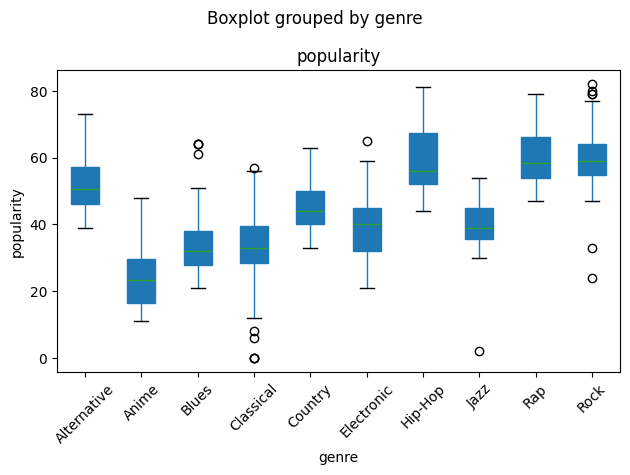

In [ ]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_dirty.txt'
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

print("Shape before one-hot encoding:", df.shape)

categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns , drop_first = True)

print("Shape after one-hot encoding:", df_encoded.shape)


df.boxplot(column='popularity', by='genre', patch_artist=True)
plt.xlabel('genre')
plt.ylabel('popularity')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# Task 2

In [ ]:
X = df_encoded.drop(columns=['popularity'])
y = df_encoded['popularity']
np.random.seed(42)

ridge_model = Ridge(alpha=0.2)
kf = KFold(n_splits=6, shuffle=True, random_state=42)



kf = KFold(n_splits=6, shuffle=True, random_state=42)
rmse_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ridge_model.fit(X_train, y_train)

    y_pred = ridge_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)


average_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
target_std = np.std(y)

print(f"Average RMSE: {average_rmse}")
print(f"Standard Deviation of the target array: {target_std}")


#I am not sure how to evaluate this model performance. RMSE is lower that STD so ... it's decent..?



Average RMSE: 8.199562450329955
Standard Deviation of the target array: 14.021569099070199


# Task 3

In [ ]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_dirty_missing_vals.txt'
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

print("Shape of input dataFrame:", df.shape)

missing_percentages = df.isnull().mean().sort_values(ascending=False)
print("\nPercentage of missing values:")
print(missing_percentages)


columns_to_drop_rows = missing_percentages[missing_percentages < 0.05].index.tolist()
print(f"\nColumns/Variables with missing values less than 5% of the dataset: {columns_to_drop_rows}")
df_cleaned = df.dropna(subset=columns_to_drop_rows)

for i in range(len(df_cleaned)):
    if df_cleaned.iloc[i]['genre'] == 'Rock':
        df_cleaned.iloc[i, df_cleaned.columns.get_loc('genre')] = int(1)
    else:
        df_cleaned.iloc[i, df_cleaned.columns.get_loc('genre')] = int(0)

df_cleaned['genre'] = df_cleaned['genre'].astype(int)


print("\nFirst five entries in `genre` column:")
print(df_cleaned['genre'].head())



print(f"\nShape of preprocessed dataframe: {df_cleaned.shape}")

Shape of input dataFrame: (1000, 12)

Percentage of missing values:
acousticness        0.200
energy              0.200
danceability        0.143
valence             0.143
duration_ms         0.091
instrumentalness    0.091
speechiness         0.059
liveness            0.046
tempo               0.046
loudness            0.044
popularity          0.031
genre               0.008
dtype: float64

Columns/Variables with missing values less than 5% of the dataset: ['liveness', 'tempo', 'loudness', 'popularity', 'genre']

First five entries in `genre` column:
1    0
2    1
3    1
5    1
6    0
Name: genre, dtype: int64

Shape of preprocessed dataframe: (892, 12)


<ipython-input-40-1de949b36914>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['genre'] = df_cleaned['genre'].astype(int)


# Task 4

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       134
           1       0.52      0.56      0.54       134

    accuracy                           0.53       268
   macro avg       0.53      0.53      0.53       268
weighted avg       0.53      0.53      0.53       268



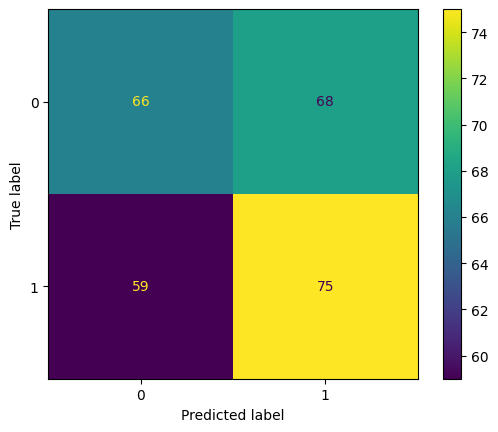

In [ ]:
X = df_cleaned.drop(columns=['genre'])
y = df_cleaned['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()




# Task 5

In [ ]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_clean.csv'
df = pd.read_csv(file_path)

print(df.head())

df = df.drop(columns=['Unnamed: 0'])



X = df.drop(columns=['loudness'])
y = df['loudness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline_no_scaling = Pipeline([
    ('lasso', Lasso(alpha=0.5, random_state=42))
])

pipeline_no_scaling.fit(X_train, y_train)
y_pred_no_scaling = pipeline_no_scaling.predict(X_test)
r2_no_scaling = r2_score(y_test, y_pred_no_scaling)

pipeline_scaling = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.5, random_state=42))
])

pipeline_scaling.fit(X_train, y_train)
y_pred_scaling = pipeline_scaling.predict(X_test)
r2_scaling = r2_score(y_test, y_pred_scaling)


print(f"\n\nWithout scaling: {r2_no_scaling}")
print(f"With scaling: {r2_scaling}")
#Scaling imporved the performance significantly

   Unnamed: 0  popularity  acousticness  danceability  duration_ms  energy  \
0       36506        60.0      0.896000         0.726     214547.0   0.177   
1       37591        63.0      0.003840         0.635     190448.0   0.908   
2       37658        59.0      0.000075         0.352     456320.0   0.956   
3       36060        54.0      0.945000         0.488     352280.0   0.326   
4       35710        55.0      0.245000         0.667     273693.0   0.647   

   instrumentalness  liveness  loudness  speechiness    tempo  valence  genre  
0          0.000002    0.1160   -14.824       0.0353   92.934    0.618      1  
1          0.083400    0.2390    -4.795       0.0563  110.012    0.637      1  
2          0.020300    0.1250    -3.634       0.1490  122.897    0.228      1  
3          0.015700    0.1190   -12.020       0.0328  106.063    0.323      1  
4          0.000297    0.0633    -7.787       0.0487  143.995    0.300      1  


Without scaling: 0.5031316281225606
With scaling:

# Task 6

In [65]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_clean.csv'
df = pd.read_csv(file_path)

df = df.drop(columns=['Unnamed: 0'])
StopIteration = 10000

X = df.drop(columns=['genre'])
y = df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

pipeline_no_scaling = Pipeline([
    ('logreg', LogisticRegression(random_state=21))
])

grid_no_scaling = GridSearchCV(pipeline_no_scaling, {'logreg__C': np.linspace(0.001, 1.0, 20)}, cv=5)
grid_no_scaling.fit(X_train, y_train)
best_no_scaling = grid_no_scaling.best_estimator_
y_pred_no_scaling = best_no_scaling.predict(X_test)
accuracy_no_scaling = accuracy_score(y_test, y_pred_no_scaling)




pipeline_scaling = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=21))
])

grid_scaling = GridSearchCV(pipeline_scaling, {'logreg__C': np.linspace(0.001, 1.0, 20)}, cv=5)
grid_scaling.fit(X_train, y_train)
best_scaling = grid_scaling.best_estimator_
y_pred_scaling = best_scaling.predict(X_test)
accuracy_scaling = accuracy_score(y_test, y_pred_scaling)



print(f"Without scaling: {accuracy_no_scaling}")
print(f"Without scaling best params: {grid_no_scaling.best_params_}")
print(f"With scaling: {accuracy_scaling}")
print(f"With scaling best params: {grid_scaling.best_params_}")

#For some reason the results are different fomr the expected (from the github task ones), but Scaling still improved the score.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Without scaling: 0.665
Without scaling best params: {'logreg__C': 0.2113157894736842}
With scaling: 0.875
With scaling best params: {'logreg__C': 0.1061578947368421}


# Task 7

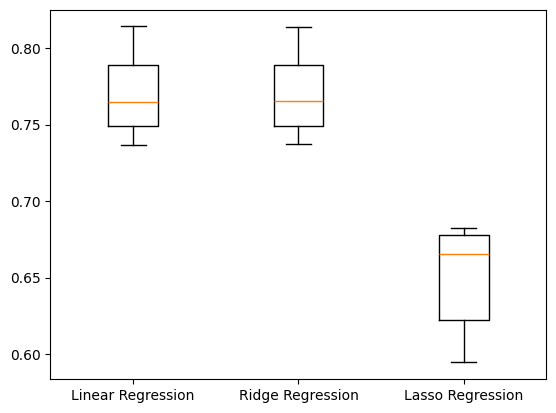

In [ ]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_clean.csv'
df = pd.read_csv(file_path)

df = df.drop(columns=['Unnamed: 0'])

X = df.drop(columns=['energy'])
y = df['energy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.1, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42)
}

cv = KFold(n_splits=6, shuffle=True, random_state=42)
model_scores = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    model_scores[name] = cv_scores




plt.boxplot(model_scores.values(), labels=model_scores.keys())
plt.show()

# Linear Regresion и Ridge Regression работят еднакво добре



# Task 8

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


linear_model = LinearRegression()
ridge_model = Ridge(alpha=0.1, random_state=42)
linear_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)


y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_ridge = ridge_model.predict(X_test_scaled)


rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"Linear Regression Test Set RMSE: {rmse_linear}")
print(f"Ridge Test Set RMSE: {rmse_ridge}")

Linear Regression Test Set RMSE: 0.11109818526605353
Ridge Test Set RMSE: 0.11110048128156672


# Task 9

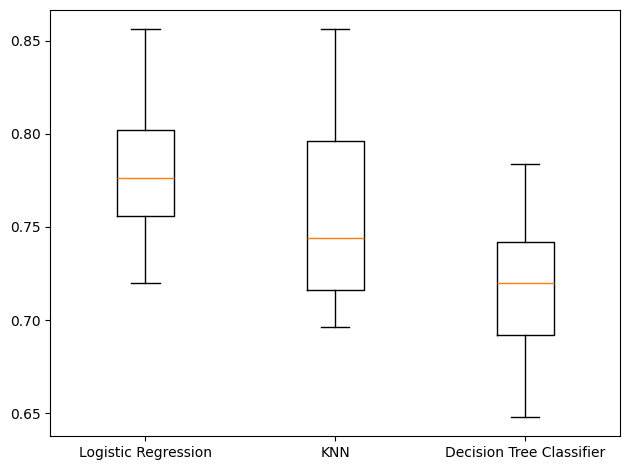

In [ ]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_clean.csv'
df = pd.read_csv(file_path)


df = df.drop(columns=['Unnamed: 0'])

median_popularity = df['popularity'].median()
df['popularity'] = (df['popularity'] >= median_popularity).astype(int)


X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_model = LogisticRegression(random_state=42)
knn_model = KNeighborsClassifier()
decision_tree_model = DecisionTreeClassifier(random_state=42)


cv = KFold(n_splits=6, shuffle=True, random_state=12)
models = {
    'Logistic Regression': logistic_model,
    'KNN': knn_model,
    'Decision Tree Classifier': decision_tree_model
}

results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv)
    results[model_name] = cv_scores


plt.boxplot(results.values(), labels=results.keys())
plt.tight_layout()
plt.show()

# Logistic regression performs the best



# Task 10

In [ ]:
file_path = '/content/drive/My Drive/ML_24-25/Data/music_dirty_missing_vals.txt'
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

df['genre'] = (df['genre'] == 'Rock').astype(int)
X = df.drop(columns=['genre'])
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

param_grid = {
    'logreg__solver': ['newton-cg', 'saga', 'lbfgs'],
    'logreg__C': np.linspace(0.001, 1.0, 10)
}

grid_search = GridSearchCV(pipeline, param_grid)
grid_search.fit(X_train, y_train)


print(f"Tuned Logistic Regression Parameters: {grid_search.best_params_}")
print(f"Accuracy: {round(grid_search.best_score_ , 2)}")


Tuned Logistic Regression Parameters: {'logreg__C': 0.223, 'logreg__solver': 'newton-cg'}
Accuracy: 0.84
